In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import folium
from folium import plugins 
from folium.plugins import HeatMap
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [7]:
! pip install telethon

In [96]:
import pandas as pd
from telethon.sync import TelegramClient

name = 'anon' 
api_id = input()
api_hash = input() 
chat = 't.me/elonmusktwitter'

data = [] # stores all our data 

async with TelegramClient(name, api_id, api_hash) as client:
    async for message in client.iter_messages(chat):
        data.append([message.sender_id, message.text, message.date])


df = pd.DataFrame(data, columns=['SENDER', 'MESSAGE', 'DATE']) # creates a new dataframe




In [97]:
df['DATE'] = df['DATE'].dt.floor('H')
df['DATE'] = df['DATE'].dt.strftime("%Y-%m-%d %H:%M:%S")

In [98]:
df.rename(columns={'DATE': 'date'}, inplace=True)
df.head()

,SENDER,MESSAGE,date
0,-1001153434921,@PeterDiamandis Write it on Twitter! Our algor...,2023-05-23 16:00:00
1,-1001153434921,@Kristennetten It’s pretty wild in the Notes w...,2023-05-23 16:00:00
2,-1001153434921,@levelsio Good idea — Elon Musk (@elonmusk) [M...,2023-05-23 14:00:00
3,-1001153434921,@Gfilche @neuralink Human output data rate is ...,2023-05-23 00:00:00
4,-1001153434921,@AviSchiffmann Neuralink — Elon Musk (@elonmus...,2023-05-23 00:00:00


In [99]:
df = df.dropna(subset=['MESSAGE'])
df = df[df['MESSAGE'] != ""]

In [100]:
df.head(100)

,SENDER,MESSAGE,date
0,-1001153434921,@PeterDiamandis Write it on Twitter! Our algor...,2023-05-23 16:00:00
1,-1001153434921,@Kristennetten It’s pretty wild in the Notes w...,2023-05-23 16:00:00
2,-1001153434921,@levelsio Good idea — Elon Musk (@elonmusk) [M...,2023-05-23 14:00:00
3,-1001153434921,@Gfilche @neuralink Human output data rate is ...,2023-05-23 00:00:00
4,-1001153434921,@AviSchiffmann Neuralink — Elon Musk (@elonmus...,2023-05-23 00:00:00
...,...,...,...
95,-1001153434921,🤯🤯 https://t.co/651ELItFSY — Elon Musk (@elonm...,2023-05-19 01:00:00
96,-1001153434921,@shellenberger @galexybrane “FBI says it won’t...,2023-05-19 01:00:00
97,-1001153434921,@chazman @Tesla The Tesla AI/software team is ...,2023-05-19 00:00:00
98,-1001153434921,"@ylecun 🤣 — Elon Musk (@elonmusk) [May 18, 202...",2023-05-19 00:00:00


In [101]:
btc_dataset = pd.read_csv("/Users/Admin/Desktop/Elon-Musk-Cryptocurrency-Influence-main/BTC-Hourly.csv")
btc_dataset.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [102]:
# Keyword Matching for dataseet
crypto_keywords = ["Bitcoin", "BTC", "Crypto", "Cryptocurrency", "Dogecoin", "Bit coin", "Cryptomarket", "Market", "crypto", "bitcoin"]
df['is_crypto_related'] = False

for keyword in crypto_keywords:
    df['is_crypto_related'] |= df['MESSAGE'].str.contains(keyword, case=False)

df = df.sort_values('date')
btc_dataset = btc_dataset.sort_values('date')

# merging the datasets
df['date'] = pd.to_datetime(df['date'])
btc_dataset['date'] = pd.to_datetime(btc_dataset['date'])
merged_data = pd.merge_asof(df, btc_dataset, left_on='date', right_on='date')
grouped_data = merged_data.groupby('SENDER')
grouped_data.head()

# Mean Bitcoin before and after
hours_before = 48 
hours_after = 48  

mean_prices = []
dates = []

for sender, data in grouped_data:
    tweet_dates = data['date']
    for tweet_date in tweet_dates:
        start_time = tweet_date - pd.Timedelta(hours=hours_before)
        end_time = tweet_date + pd.Timedelta(hours=hours_after)
        prices_before = data[(data['date'] >= start_time) & (data['date'] < tweet_date)]['close']
        prices_after = data[(data['date'] > tweet_date) & (data['date'] <= end_time)]['close']
        mean_before = prices_before.mean()
        mean_after = prices_after.mean()
        mean_prices.append(mean_after - mean_before)
        dates.append(tweet_date)

# new result df
result_df = pd.DataFrame({'date': dates, 'price_change': mean_prices})

# defining threshold for the price movement
threshold = 2500
significant_changes = result_df[abs(result_df['price_change']) > threshold]

# falls and jumps
price_jumps = significant_changes[significant_changes['price_change'] > 0]
price_falls = significant_changes[significant_changes['price_change'] < 0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=price_jumps['date'], y=price_jumps['price_change'],
                         mode='markers', marker=dict(color='green'), name='Price jump'))
fig.add_trace(go.Scatter(x=price_falls['date'], y=price_falls['price_change'],
                         mode='markers', marker=dict(color='red'), name='Price fall'))
fig.update_layout(title='Bitcoins price movement after Elon Musks Tweets',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Price Movement'))
fig.show()


In [103]:
from math import ceil, sqrt

def movmean(v, kb, kf):
    """
    Computes the mean with a window of length kb+kf+1 that includes the element 
    in the current position, kb elements backward, and kf elements forward.
    Nonexisting elements at the edges get substituted with NaN.
    Args:
        v (list(float)): List of values.
        kb (int): Number of elements to include before current position
        kf (int): Number of elements to include after current position
    Returns:
        list(float): List of the same size as v containing the mean values
    """
    m = len(v) * [np.nan]
    for i in range(kb, len(v)-kf):
        m[i] = np.mean(v[i-kb:i+kf+1])
    return m


def LeeMykland(S, sampling, significance_level=0.01):
    """
    "Jumps in Equilibrium Prices and Market Microstructure Noise"
    - by Suzanne S. Lee and Per A. Mykland
    
    "https://galton.uchicago.edu/~mykland/paperlinks/LeeMykland-2535.pdf"
    
    Args:
        S (list(float)): An array containing prices, where each entry 
                         corresponds to the price sampled every 'sampling' minutes.
        sampling (int): Minutes between entries in S
        significance_level (float): Defaults to 1% (0.001)
        
    Returns:
        A pandas dataframe containing a row covering the interval 
        [t_i, t_i+sampling] containing the following values:
        J:   Binary value is jump with direction (sign)
        L:   L statistics
        T:   Test statistics
        sig: Volatility estimate
    """
    tm = 252*24*60 # Trading minutes
    k   = ceil(sqrt(tm/sampling))
    r = np.append(np.nan, np.diff(np.log(S)))
    bpv = np.multiply(np.absolute(r[:]), np.absolute(np.append(np.nan, r[:-1])))
    bpv = np.append(np.nan, bpv[0:-1]).reshape(-1,1) # Realized bipower variation
    sig = np.sqrt(movmean(bpv, k-3, 0)) # Volatility estimate
    L   = r/sig
    n   = np.size(S) # Length of S
    c   = (2/np.pi)**0.5
    Sn  = c*(2*np.log(n))**0.5
    Cn  = (2*np.log(n))**0.5/c - np.log(np.pi*np.log(n))/(2*c*(2*np.log(n))**0.5)
    beta_star   = -np.log(-np.log(1-significance_level)) # Jump threshold
    T   = (abs(L)-Cn)*Sn
    J   = (T > beta_star).astype(float)
    J   = J*np.sign(r) # Add direction
    # First k rows are NaN involved in bipower variation estimation are set to NaN.
    J[0:k] = np.nan
    # Build and return result dataframe
    return pd.DataFrame({'L': L,'sig': sig, 'T': T,'J':J})


prices = merged_data['open'].tolist()

sampling = 60 

result = LeeMykland(prices, sampling)

merged_data = pd.concat([merged_data, result], axis=1)

merged_data.head()


/var/folders/49/1bqwbw2539j4jwl3zcbb_hb00000gn/T/ipykernel_69481/3454725003.py:48: RuntimeWarning:

invalid value encountered in true_divide



,SENDER,MESSAGE,date,is_crypto_related,unix,symbol,open,high,low,close,Volume BTC,Volume USD,L,sig,T,J
0,-1001153434921,"I love science, bitch!",2018-09-21 05:00:00,False,1537506000,BTC/USD,6543.23,6547.45,6519.56,6531.34,1076859.99,164.86,NaN,NaN,NaN,NaN
1,-1001153434921,Here's a [@Tesla](https://twitter.com/Tesla?re...,2018-09-21 19:00:00,False,1537556400,BTC/USD,6733.72,6775.34,6726.76,6753.09,2588323.98,383.44,NaN,NaN,NaN,NaN
2,-1001153434921,"Скоро осуществим твиты на русском, ведётся раб...",2018-09-21 19:00:00,False,1537556400,BTC/USD,6733.72,6775.34,6726.76,6753.09,2588323.98,383.44,NaN,NaN,NaN,NaN
3,-1001153434921,Probably 2028 for a base to be built— Elon Mus...,2018-09-21 21:00:00,False,1537563600,BTC/USD,6708.33,6741.59,6691.28,6713.09,1683900.57,250.84,NaN,NaN,NaN,NaN
4,-1001153434921,[pic.twitter.com/Fn0hKJd3uJ](https://t.co/Fn0h...,2018-09-21 21:00:00,False,1537563600,BTC/USD,6708.33,6741.59,6691.28,6713.09,1683900.57,250.84,NaN,NaN,NaN,NaN


In [104]:
merged_data.head(555)

,SENDER,MESSAGE,date,is_crypto_related,unix,symbol,open,high,low,close,Volume BTC,Volume USD,L,sig,T,J
0,-1001153434921,"I love science, bitch!",2018-09-21 05:00:00,False,1537506000,BTC/USD,6543.23,6547.45,6519.56,6531.34,1076859.99,164.86,NaN,NaN,NaN,NaN
1,-1001153434921,Here's a [@Tesla](https://twitter.com/Tesla?re...,2018-09-21 19:00:00,False,1537556400,BTC/USD,6733.72,6775.34,6726.76,6753.09,2588323.98,383.44,NaN,NaN,NaN,NaN
2,-1001153434921,"Скоро осуществим твиты на русском, ведётся раб...",2018-09-21 19:00:00,False,1537556400,BTC/USD,6733.72,6775.34,6726.76,6753.09,2588323.98,383.44,NaN,NaN,NaN,NaN
3,-1001153434921,Probably 2028 for a base to be built— Elon Mus...,2018-09-21 21:00:00,False,1537563600,BTC/USD,6708.33,6741.59,6691.28,6713.09,1683900.57,250.84,NaN,NaN,NaN,NaN
4,-1001153434921,[pic.twitter.com/Fn0hKJd3uJ](https://t.co/Fn0h...,2018-09-21 21:00:00,False,1537563600,BTC/USD,6708.33,6741.59,6691.28,6713.09,1683900.57,250.84,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,-1001153434921,Obv must be more pointy tho— Elon Musk (@elonm...,2019-01-11 10:00:00,False,1547200800,BTC/USD,3635.82,3642.51,3605.73,3627.87,2099188.65,578.06,-0.604066,0.006199,-15.975623,-0.0
551,-1001153434921,Falcon 9 and 10 Iridium NEXT satellites vertic...,2019-01-11 11:00:00,False,1547204400,BTC/USD,3627.87,3640.00,3626.22,3640.00,1544831.08,425.28,-0.351428,0.006229,-16.873535,-0.0
552,-1001153434921,"Ok— Elon Musk (@elonmusk) [January 12, 2019](h...",2019-01-12 21:00:00,False,1547326800,BTC/USD,3632.35,3641.12,3626.27,3628.93,233169.99,64.20,0.197857,0.006237,-17.419349,0.0
553,-1001153434921,View of SpaceX Dragon 1 berthed with [@Space_S...,2019-01-13 18:00:00,False,1547402400,BTC/USD,3519.40,3523.96,3499.55,3504.24,2120489.27,604.00,-5.062158,0.006240,-0.130901,-0.0


In [105]:
filtered_df = merged_data[merged_data['J'] == 1]

filtered_df.head()

,SENDER,MESSAGE,date,is_crypto_related,unix,symbol,open,high,low,close,Volume BTC,Volume USD,L,sig,T,J
129,-1001153434921,Tiny wizard 🧙&zwj;♂️— Elon Musk (@elonmusk) [N...,2018-11-28 08:00:00,False,1543392000,BTC/USD,4020.41,4039.41,3950.98,3961.00,2658186.89,665.04,9.117252,0.008822,14.281512,1.0
279,-1001153434921,Totally false. Buried in this incredibly misle...,2018-12-18 06:00:00,False,1545112800,BTC/USD,3483.43,3499.96,3481.08,3488.56,920554.59,263.73,11.927197,0.006852,24.268472,1.0
332,-1001153434921,"Thanks, will consider next year— Elon Musk (@e...",2018-12-20 15:00:00,False,1545318000,BTC/USD,4030.10,4070.68,3980.83,4022.53,3807600.11,944.24,10.712101,0.006986,19.949843,1.0
366,-1001153434921,"Thanks!— Elon Musk (@elonmusk) [December 23, 2...",2018-12-23 01:00:00,False,1545526800,BTC/USD,3992.68,4020.00,3970.03,3990.63,958321.82,239.90,9.301475,0.003504,14.936267,1.0
382,-1001153434921,When it’s no longer noticeable over Planck’s l...,2018-12-24 07:00:00,False,1545634800,BTC/USD,4186.58,4206.58,4179.90,4187.14,1293667.41,308.51,19.688731,0.002942,51.854124,1.0


In [107]:
final_df = filtered_df[(filtered_df['is_crypto_related'] == True) & (filtered_df['J'] == 1)]
final_df.head()

,SENDER,MESSAGE,date,is_crypto_related,unix,symbol,open,high,low,close,Volume BTC,Volume USD,L,sig,T,J
8611,-1001153434921,Spoke with North American Bitcoin miners. They...,2021-05-24 20:00:00,True,1621886400,BTC/USD,39680.99,39960.0,38800.49,39024.9,629.970075,2.458452e+07,6.543983,0.019404,5.135728,1.0


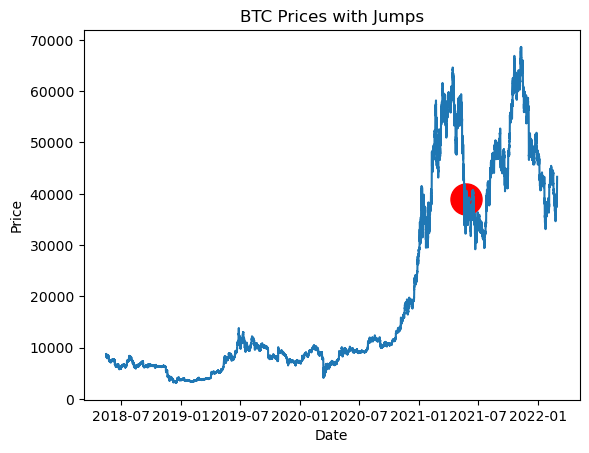

In [119]:
import matplotlib.pyplot as plt

plt.plot(btc_dataset['date'], btc_dataset['close'], label='Prices')

jump_indices = final_df[final_df['J'] == 1].index
jump_dates = final_df.loc[jump_indices, 'date']
jump_prices = final_df.loc[jump_indices, 'close']
plt.scatter(jump_dates, jump_prices, color='red', marker='o', s=500, alpha=1, label='Jumps')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Prices with Jumps')
plt.show()
